# FLIGHT PRICE PREDICTION

In [1]:
# importing libraries and filtering warnings
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import SCORERS
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
#Reading DF
df=pd.read_excel('data.xlsx')

In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
# Last 5 rows
df.tail()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [7]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [8]:
# Size of df
df.size

117513

In [9]:
# rows*cols in df
df.shape

(10683, 11)

In [10]:
df=df.dropna()
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [11]:
dict={}
for i in df.columns:
    dict[i]=df[i].value_counts().shape[0]
    
pd.DataFrame(dict,index=['Unique']).transpose()

,Unique
Airline,12
Date_of_Journey,44
Source,5
Destination,6
Route,128
Dep_Time,222
Arrival_Time,1343
Duration,368
Total_Stops,5
Additional_Info,10


In [12]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


splitting date of journey feature to day and month

In [13]:
df["Journey_day"] = pd.to_datetime(df.Date_of_Journey, format="%d/%m/%Y").dt.day
df['Journey_month']=pd.to_datetime(df.Date_of_Journey,format='%d/%m/%Y').dt.month
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [14]:
df.drop(["Date_of_Journey"], axis = 1, inplace = True)
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


splitting Dep_Time feature to hours and minutes

In [15]:
df['Dep_Hr']=pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_mins']=pd.to_datetime(df['Dep_Time']).dt.minute
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_Hr,Dep_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [16]:
df.drop(['Dep_Time'],axis=1,inplace=True)
df.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_Hr,Dep_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [17]:
df['Arrival_Hr']=pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_mins']=pd.to_datetime(df['Arrival_Time']).dt.minute
df.drop(['Arrival_Time'],axis=1,inplace=True)
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_Hr,Dep_mins,Arrival_Hr,Arrival_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [18]:
duration=list(df['Duration'])
for i in range(len(duration)):
    if len(duration[i].split()) !=2:
        if 'h' in duration[i]:
            duration[i]=duration[i].strip()+' 0m'
        else:
            duration[i]='0h '+duration[i]

duration_hour=[]
duration_mins=[]
for i in range(len(duration)):
    duration_hour.append(int(duration[i].split(sep='h')[0]))
    duration_mins.append(int(duration[i].split(sep='m')[0].split()[-1]))

In [19]:
df['Duration_Hr']=duration_hour
df['Duration_min']=duration_mins

In [20]:
df.drop(['Duration'],axis=1,inplace=True)
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_Hr,Dep_mins,Arrival_Hr,Arrival_mins,Duration_Hr,Duration_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Source           10682 non-null  object
 2   Destination      10682 non-null  object
 3   Route            10682 non-null  object
 4   Total_Stops      10682 non-null  object
 5   Additional_Info  10682 non-null  object
 6   Price            10682 non-null  int64 
 7   Journey_day      10682 non-null  int64 
 8   Journey_month    10682 non-null  int64 
 9   Dep_Hr           10682 non-null  int64 
 10  Dep_mins         10682 non-null  int64 
 11  Arrival_Hr       10682 non-null  int64 
 12  Arrival_mins     10682 non-null  int64 
 13  Duration_Hr      10682 non-null  int64 
 14  Duration_min     10682 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 1.3+ MB


In [22]:
df['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [23]:
df.drop(['Additional_Info','Route'],axis=1,inplace=True)
df.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_Hr,Dep_mins,Arrival_Hr,Arrival_mins,Duration_Hr,Duration_min
0,IndiGo,Banglore,New Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1 stop,13302,1,3,16,50,21,35,4,45


In [24]:
for column in df.columns:
    print(df[column].value_counts(),'\n\n\n')

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64 



Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64 



Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64 



1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64 



10262    258
10844    212
7229     162
4804     160
4823     131
        ... 
14153

In [25]:
df['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
df.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_Hr,Dep_mins,Arrival_Hr,Arrival_mins,Duration_Hr,Duration_min
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


<AxesSubplot:xlabel='Airline', ylabel='count'>

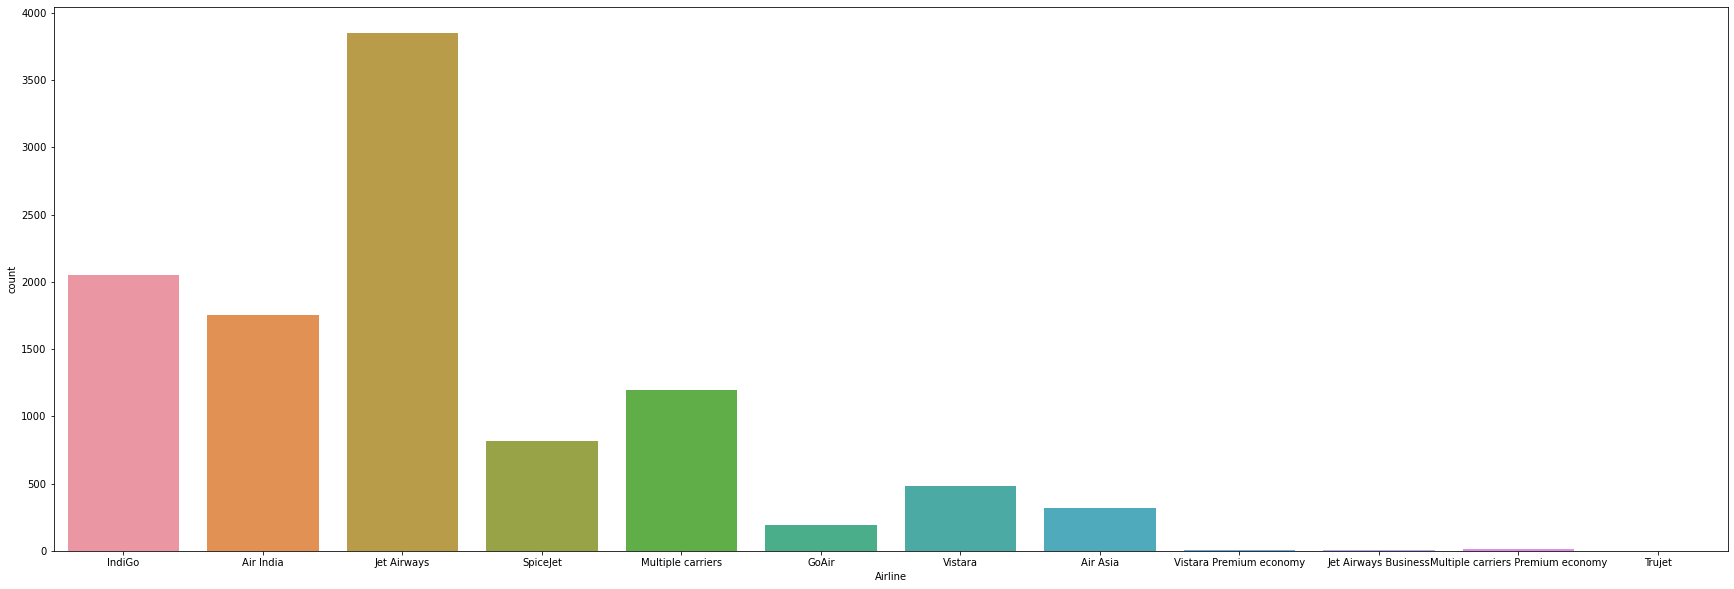

In [26]:
plt.figure(figsize=(30,10))
sns.countplot('Airline',data=df)

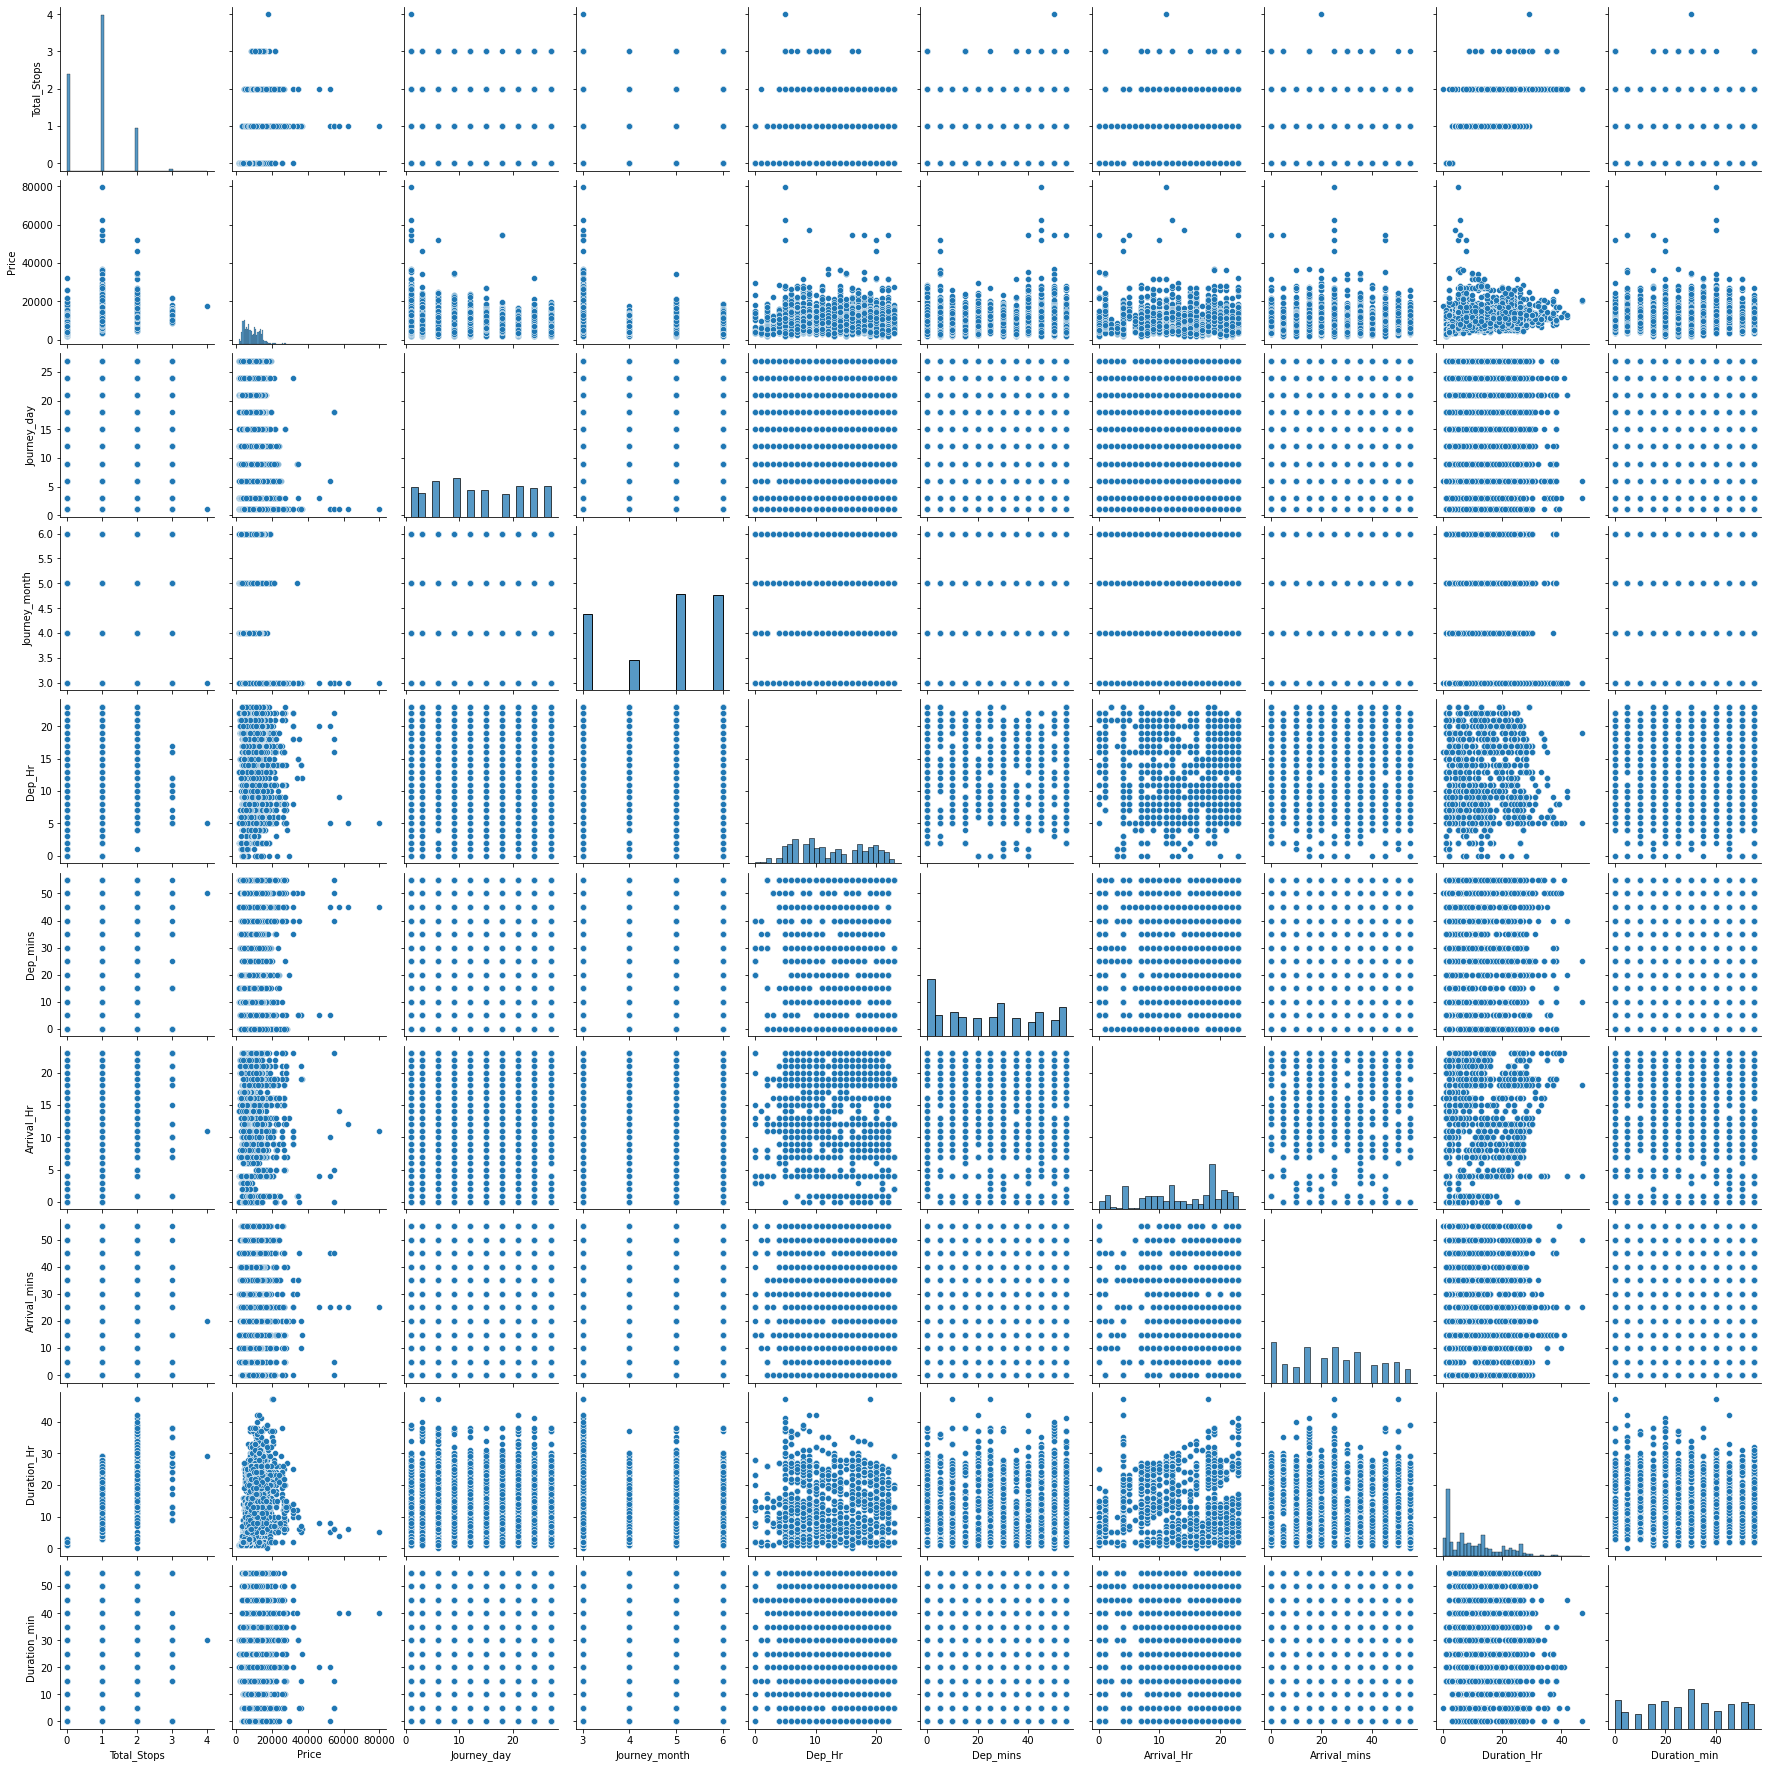

In [27]:
sns.pairplot(data=df)

<AxesSubplot:>

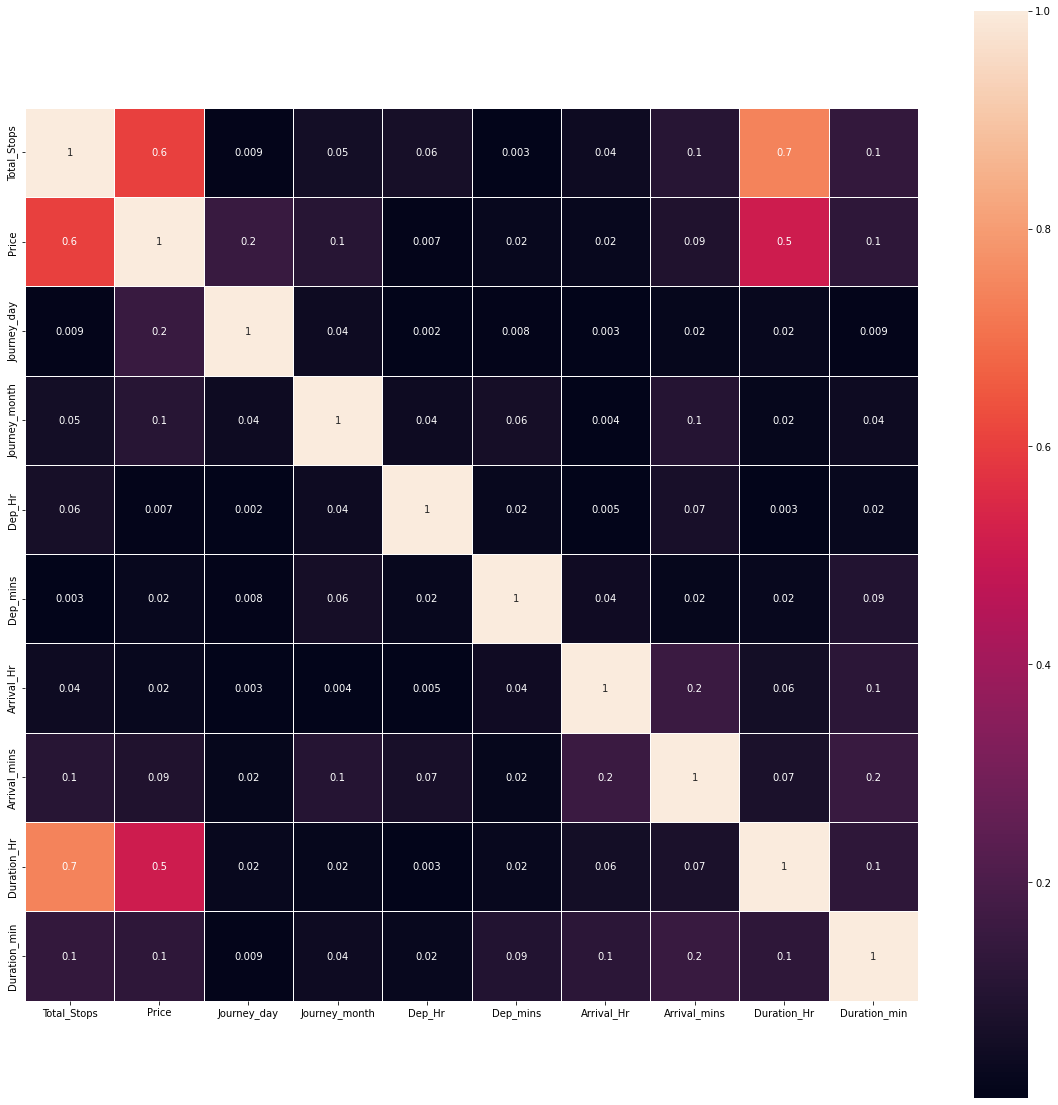

In [28]:
df_corr=df.corr().abs()
plt.figure(figsize=(20,20))
sns.heatmap(df_corr,annot=True,square=True,fmt='.1g',linewidth=1)

In [29]:
# <<<<<<<<<< Need to use encoder to encode non-numerical features to numerical features >>>>>>>>>>>>>
for col in df.columns:
    if df[col].dtypes=='object':
        encoder=LabelEncoder()
        df[col]=encoder.fit_transform(df[col])

In [30]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_Hr,Dep_mins,Arrival_Hr,Arrival_mins,Duration_Hr,Duration_min
0,3,0,5,0,3897,24,3,22,20,1,10,2,50
1,1,3,0,2,7662,1,5,5,50,13,15,7,25
2,4,2,1,2,13882,9,6,9,25,4,25,19,0
3,3,3,0,1,6218,12,5,18,5,23,30,5,25
4,3,0,5,1,13302,1,3,16,50,21,35,4,45


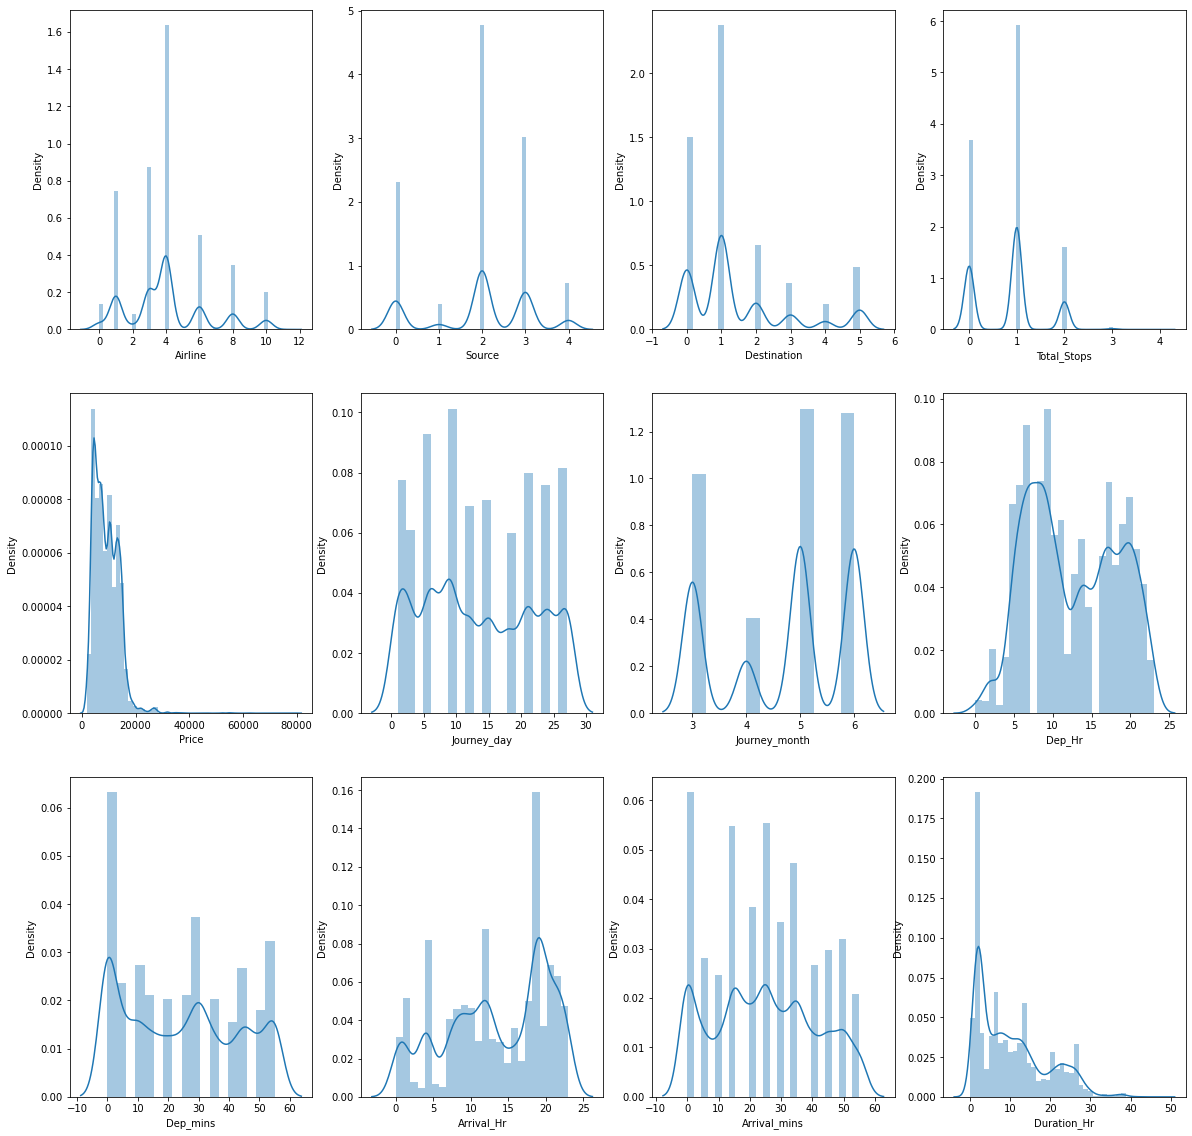

In [31]:
#Distribution of the df
plt.figure(figsize=(20,20),facecolor='white')
plotnumber=1
for i in df:
        if plotnumber<=12:
            ax=plt.subplot(3,4,plotnumber)
            sns.distplot(df[i])
            plt.xlabel(i)
        plotnumber+=1

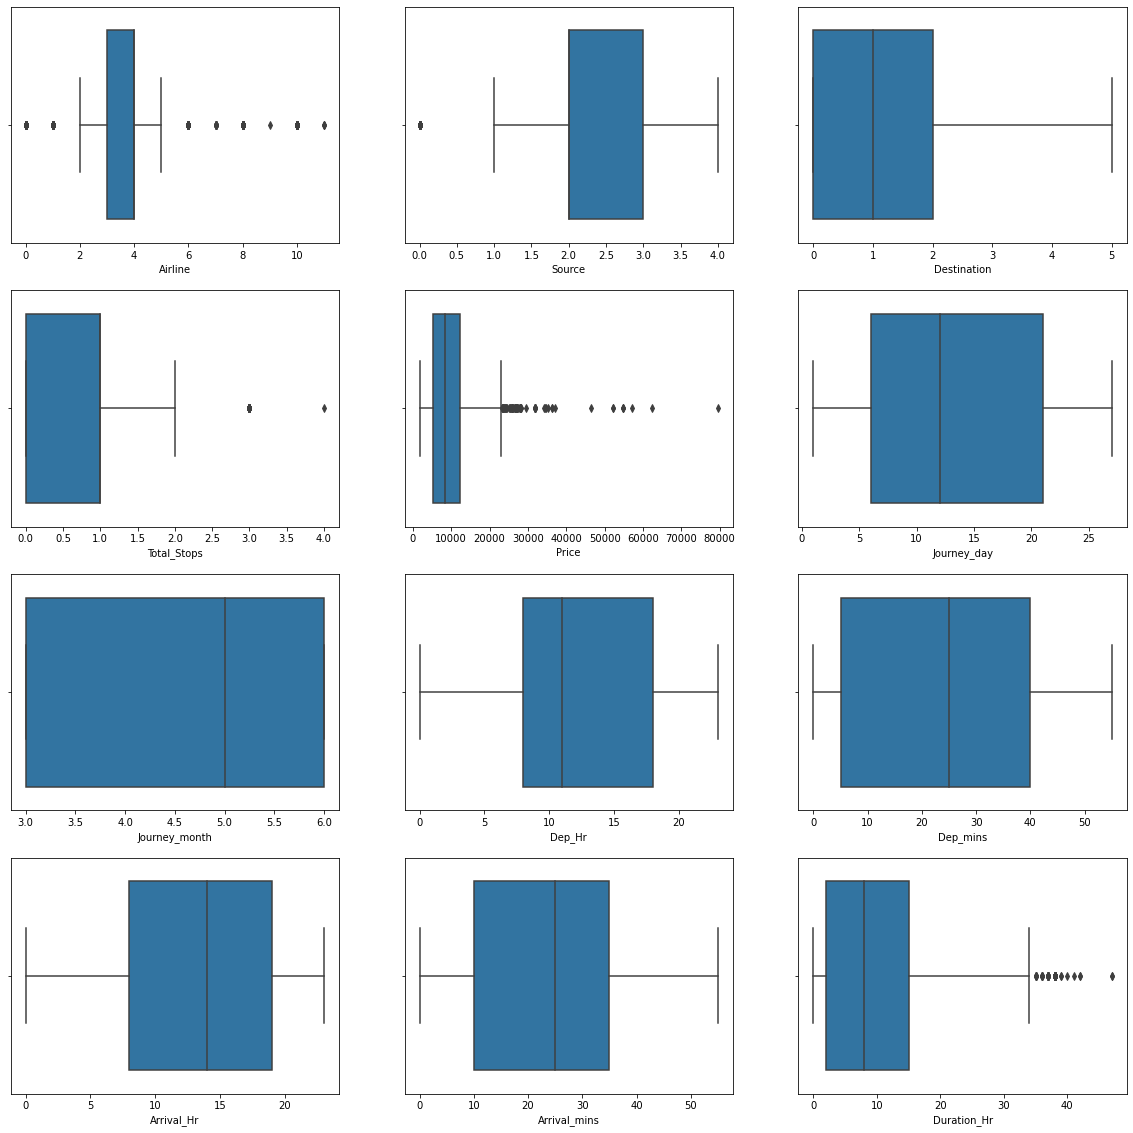

In [32]:
# Visualising outliers

plt.figure(figsize=(20,20))
plotnumber=1
for i in df:
        if plotnumber<=12:
            ax=plt.subplot(4,3,plotnumber)
            sns.boxplot(df[i])
            plt.xlabel(i)
        plotnumber+=1

In [33]:
#Removing outliers using zscore
z=np.abs(stats.zscore(df))
np.where(z>3)

(array([  123,   226,   396,   402,   486,   510,   553,   597,   628,
          657,   785,   826,   919,   936,   946,   959,   966,   969,
          975,  1067,  1113,  1196,  1218,  1246,  1341,  1346,  1424,
         1442,  1466,  1478,  1496,  1551,  1629,  1654,  1657,  1665,
         1785,  1791,  1804,  1918,  2055,  2099,  2108,  2172,  2172,
         2495,  2553,  2556,  2618,  2623,  2633,  2635,  2641,  2654,
         2693,  2718,  2718,  2814,  2822,  2924,  3032,  3111,  3157,
         3220,  3257,  3317,  3400,  3457,  3496,  3535,  3568,  3584,
         3700,  3790,  3815,  3815,  3945,  3966,  4012,  4047,  4118,
         4118,  4463,  4463,  4521,  4655,  4655,  4676,  4760,  4829,
         5013,  5050,  5136,  5372,  5439,  5446,  5516,  5662,  5701,
         5701,  5710,  5711,  5719,  5738,  5745,  5782,  5838,  5856,
         5933,  5947,  5953,  5986,  5996,  6059,  6085,  6314,  6321,
         6407,  6444,  6476,  6576,  6588,  6599,  6605,  6884,  6884,
      

In [34]:
index=(np.where(z>3)[0])
df=df.drop(df.index[index])

In [35]:
df.shape

(10488, 13)

In [36]:
# Skew values before treatment
df.skew()

Airline          0.730245
Source          -0.436551
Destination      1.262474
Total_Stops      0.229781
Price            0.415847
Journey_day      0.107486
Journey_month   -0.417433
Dep_Hr           0.100324
Dep_mins         0.172811
Arrival_Hr      -0.362901
Arrival_mins     0.106791
Duration_Hr      0.765124
Duration_min    -0.097756
dtype: float64

In [37]:
df.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Price',
       'Journey_day', 'Journey_month', 'Dep_Hr', 'Dep_mins', 'Arrival_Hr',
       'Arrival_mins', 'Duration_Hr', 'Duration_min'],
      dtype='object')

In [38]:
# Separating features and labels
X=df.drop(columns=['Price'],axis=1)
y=df['Price']

In [39]:
# Treating Skew
power = PowerTransformer(method='yeo-johnson', standardize=True)
data_new = power.fit_transform(X)

In [40]:
data_new=pd.DataFrame(data_new,columns=X.columns)
data_new.skew()

Airline         -0.013733
Source          -0.236625
Destination      0.041185
Total_Stops     -0.070815
Journey_day     -0.203824
Journey_month   -0.223685
Dep_Hr          -0.107080
Dep_mins        -0.357953
Arrival_Hr      -0.353602
Arrival_mins    -0.351123
Duration_Hr     -0.030791
Duration_min    -0.378887
dtype: float64

In [41]:
X = data_new
scaler=StandardScaler()
X=scaler.fit_transform(X)

## Modelling

In [42]:
# GPU stat 
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 17% |  6% |


In [43]:
# Finding best random state
min_squared_error = 0
max_random_state = 1
for i in range(1,200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    model=XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    model.fit(X_train,y_train)
    pred= model.predict(X_test)
    root_mean_squared_error=np.sqrt(mean_squared_error(y_test,pred))
    if root_mean_squared_error<min_squared_error:
        min_squared_error=root_mean_squared_error
        max_random_state=i
        
print('lowest error is: ',min_squared_error,' on random_state ',max_random_state)

lowest error is:  0  on random_state  1


In [44]:
# List of models to be used
en = ElasticNet()
dtr = DecisionTreeRegressor(random_state=1)
rfr = RandomForestRegressor(random_state=1)
ar = AdaBoostRegressor(random_state=1)
gbr= GradientBoostingRegressor(random_state=1)
sr = SVR()
lgr=LGBMRegressor(random_state=1)
xgbr = XGBRegressor(tree_method='gpu_hist', gpu_id=0, random_state = 1)

m_list= [en,dtr,rfr,ar,gbr,sr,lgr,xgbr]

s=SCORERS
s.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [45]:
#seperating the training data and test data:-
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [46]:
# Fitting models
for m in m_list:
    m.fit(X_train,y_train)
    preds = m.predict(X_test)
    rmse= np.sqrt(mean_squared_error(y_test,preds))
    print(m)
    print('Root_mean_squared_error: ',rmse)
    print('cross validation scores below:--  \n',m)
    print('root_mean_squared_error: ',cross_val_score(m,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
    print('difference between model score and cross validation score: ',-rmse-cross_val_score(m,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
    print('\n')
    print('\n')

ElasticNet()
Root_mean_squared_error:  2846.169978534025
cross validation scores below:--  
 ElasticNet()
root_mean_squared_error:  -2857.4669064382456
difference between model score and cross validation score:  11.29692790422041




DecisionTreeRegressor(random_state=1)
Root_mean_squared_error:  2222.140394974475
cross validation scores below:--  
 DecisionTreeRegressor(random_state=1)
root_mean_squared_error:  -2157.380646346165
difference between model score and cross validation score:  -64.75974862830981




RandomForestRegressor(random_state=1)
Root_mean_squared_error:  1735.7472588452501
cross validation scores below:--  
 RandomForestRegressor(random_state=1)
root_mean_squared_error:  -1761.521757847955
difference between model score and cross validation score:  25.774499002704943




AdaBoostRegressor(random_state=1)
Root_mean_squared_error:  2493.050181732268
cross validation scores below:--  
 AdaBoostRegressor(random_state=1)
root_mean_squared_error:  -2483.381352051777
diff

## Hyper Parameter Tuning (HPT)

In [49]:
# Parameter Grid
grid_param = {'n_estimators':[int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)],
              'loss':['linear','square','exponential'],
              'learning_rate':[x for x in np.linspace(0.0001, 0.1, num = 10)]}

In [50]:
# Conducting Grid Sesarch
grid_search=GridSearchCV(AdaBoostRegressor(random_state=1),param_grid=grid_param,cv=5,n_jobs=15,verbose = 2,scoring='neg_root_mean_squared_error')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=1), n_jobs=15,
             param_grid={'learning_rate': [0.0001, 0.0112, 0.0223,
                                           0.033400000000000006,
                                           0.044500000000000005,
                                           0.055600000000000004,
                                           0.06670000000000001,
                                           0.07780000000000001, 0.0889, 0.1],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000, 1100, 1200]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [51]:
grid_search.best_params_

{'learning_rate': 0.0223, 'loss': 'exponential', 'n_estimators': 600}

In [53]:
ar = AdaBoostRegressor(random_state=1, learning_rate=0.0223,loss = 'exponential', n_estimators=600)
ar.fit(X_train,y_train)
preds = ar.predict(X_test)
rmse= np.sqrt(mean_squared_error(y_test,preds))
print(ar)
print('Root_mean_squared_error: ',rmse)
print('cross validation scores below:--  \n',ar)
print('root_mean_squared_error: ',cross_val_score(ar,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('difference between model score and cross validation score: ',-rmse-cross_val_score(ar,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('\n')
print('\n')

AdaBoostRegressor(learning_rate=0.0223, loss='exponential', n_estimators=600,
                  random_state=1)
Root_mean_squared_error:  2285.329494971734
cross validation scores below:--  
 AdaBoostRegressor(learning_rate=0.0223, loss='exponential', n_estimators=600,
                  random_state=1)
root_mean_squared_error:  -2333.002684979593
difference between model score and cross validation score:  47.67319000785892






The default parameters have provided better results than HPT. This process can be further improved by using more parameters over a large iteration, but it has not been donee due to the systems capacity.

## Saving Best Model

In [55]:
import joblib

joblib.dump(ar,'AR_best.obj')

['AR_best.obj']